In [1]:
# Final notes (Focus: image quality, autofocus issues for microscopes/cameras)
# Train on unblurred
# Models: RF, CNN, XGBoost, Resnet
# Test on blurred, and contrast pairwise if time
# Metrics: usual metrics + confidence probability distribution, look at different cell groupings (visualisation)
# Consistent visualisations in the app 

# Accuracy - loss plots
# show all models by default
# then export to csv - concat csv's: put on github
# png for other graphs

# PCA vs HOG vs not - all in report, best in shiny, message Emily 

In [2]:
# autofocus - big problem read into it:  
# look at how the different cell types change with the blurring 
# the distribution of confidence, but same results? plot the probabilities 
# try on the different cell groupings 
# non blur training, blur testing 

# My stuff 
# torch.save - to save the outputs of the model 
# maybe neaten code and turn into functions

# - PCA - look into this 
# - metadata useful?
# - HOG: look at parameters 
# - RF: labels? encoding?

# PCA
# reduces dimensionality by projecting to directions of max variance
# good at compact global representation
# but doesn't capture spatial strucure (e.g. edges, orientation)
# good if images are uniform size, when you want to reduce feature count drastically 
# e.g. many raw pixels to components
# good for random forest or SVM that don't like ultra high-dimension
# PCA is a statistical abstraction of the whole image, HOG is hand-crafted structure

# HOG
# captured edge direction and local shape info
# good at preserving spatial patterns (boundaries, contours)

## RF Model

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import shiny_data
import pandas as pd
from PIL import Image, ImageEnhance
from skimage.feature import hog
from sklearn.decomposition import PCA
from IPython.display import display
from sklearn.metrics import classification_report

# ========== Load Data ==========
Xmat_train, Xmat_val, Xmat_test, y_train_enc, y_val_enc, y_test_enc = shiny_data.load_split_images()

# ========== Utilities ==========
def store_results(results, y_true, y_pred, probs=None, blur=0, contrast=0, hog=False, pca=False, **extra_metrics):
    f1_classes = f1_score(y_true, y_pred, average=None, zero_division=0)

    entry = {
        "Blur": blur,
        "Contrast": contrast,
        "hog": hog,
        "pca": pca,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average='weighted'),
        "precision": precision_score(y_true, y_pred, average='weighted'),
        "recall": recall_score(y_true, y_pred, average='weighted'),
        "f1_class_0": f1_classes[0],
        "f1_class_1": f1_classes[1],
        "f1_class_2": f1_classes[2],
        "f1_class_3": f1_classes[3]
    }

    # === Confidence metrics ===
    if probs is not None:
        confidences = np.max(probs, axis=1)
        entry["avg_conf"] = np.mean(confidences)

        for cls in np.unique(y_pred):
            cls_conf = confidences[y_pred == cls]
            entry[f"avg_conf_class_{cls}"] = np.mean(cls_conf) if len(cls_conf) > 0 else np.nan

    entry.update(extra_metrics)
    results.append(entry)

def apply_contrast(images, factor):
    adjusted = []
    for img in images:
        pil_img = Image.fromarray((img * 255).astype('uint8'))
        enhancer = ImageEnhance.Contrast(pil_img)
        adjusted_img = enhancer.enhance(factor)
        adjusted.append(np.array(adjusted_img) / 255.0)
    return np.array(adjusted)

def extract_hog_features(images):
    hog_features = []
    for img in images:
        if img.shape[-1] == 3:
            img = Image.fromarray((img * 255).astype(np.uint8)).convert("L")
            img = np.array(img)
        features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

# ========== 1. Flatten Images ==========
X_train_flat = Xmat_train.reshape(Xmat_train.shape[0], -1)
X_val_flat   = Xmat_val.reshape(Xmat_val.shape[0], -1)
X_test_flat  = Xmat_test.reshape(Xmat_test.shape[0], -1)

# ========== 2. Fit PCA on Clean Training Data ==========
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)

# ========== 3. Extract HOG from Clean Training Data ==========
X_train_hog = extract_hog_features(Xmat_train)

# ========== 4. Prepare Empty Results Table ==========
results = []
df = pd.DataFrame(results)  # no explicit column list

Tumour images loaded
Immune images loaded
Stromal images loaded
Other images loaded


## RF no HOG or PCA

In [3]:
# BASELINE
model = RandomForestClassifier(n_estimators=100, random_state=3888)
model.fit(X_train_flat, y_train_enc)
y_pred = model.predict(X_test_flat)
y_probs = model.predict_proba(X_test_flat)
store_results(results, y_test_enc, y_pred, probs=y_probs)

# BLUR TESTS
for radius in [1, 3, 5, 7, 10]:
    X_blur_test = shiny_data.apply_blur(Xmat_test, radius)
    X_test_flat = X_blur_test.reshape(X_blur_test.shape[0], -1)
    y_pred = model.predict(X_test_flat)
    y_probs = model.predict_proba(X_test_flat)
    store_results(results, y_test_enc, y_pred, blur=radius, probs=y_probs)

# CONTRAST TESTS
for factor in [1.25, 1.5, 1.75, 2]:
    X_contrast_test = apply_contrast(Xmat_test, factor)
    X_test_flat = X_contrast_test.reshape(X_contrast_test.shape[0], -1)
    y_pred = model.predict(X_test_flat)
    y_probs = model.predict_proba(X_test_flat)
    store_results(results, y_test_enc, y_pred, contrast=factor, probs=y_probs)

# BLUR + CONTRAST TESTS
for radius in [1, 3, 5, 7, 10]:
    for factor in [1.25, 1.5, 1.75, 2]:
        X_blur = shiny_data.apply_blur(Xmat_test, radius)
        X_combo = apply_contrast(X_blur, factor)
        X_test_flat = X_combo.reshape(X_combo.shape[0], -1)
        y_pred = model.predict(X_test_flat)
        y_probs = model.predict_proba(X_test_flat)
        store_results(results, y_test_enc, y_pred, blur=radius, contrast=factor, probs=y_probs)

# Show progress
df = pd.DataFrame(results)
print("\n=== After Augmentations ===")
cols = [
    "hog", "pca", "Blur", "Contrast",
    "accuracy", "f1", "precision", "recall",
    "f1_class_0", "f1_class_1", "f1_class_2", "f1_class_3",
    "avg_conf", "avg_conf_class_0", "avg_conf_class_1", "avg_conf_class_2", "avg_conf_class_3"
]
display(df[cols].sort_values(by=["hog", "pca", "Blur", "Contrast"]).reset_index(drop=True))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa


=== After Augmentations ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,hog,pca,Blur,Contrast,accuracy,f1,precision,recall,f1_class_0,f1_class_1,f1_class_2,f1_class_3,avg_conf,avg_conf_class_0,avg_conf_class_1,avg_conf_class_2,avg_conf_class_3
0,False,False,0,0.00,0.52975,0.519056,0.522985,0.52975,0.602448,0.326599,0.505759,0.641416,0.421730,0.365404,0.356304,0.480110,0.455003
1,False,False,0,1.25,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
2,False,False,0,1.50,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
3,False,False,0,1.75,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
4,False,False,0,2.00,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
5,False,False,1,0.00,0.53100,0.519989,0.531346,0.53100,0.590017,0.341629,0.512233,0.636076,0.432130,0.365939,0.357240,0.485168,0.471721
6,False,False,1,1.25,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
7,False,False,1,1.50,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
8,False,False,1,1.75,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
9,False,False,1,2.00,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000


## PCA

In [5]:
# === PCA MODEL ===
model_pca = RandomForestClassifier(n_estimators=100, random_state=3888)
model_pca.fit(X_train_pca, y_train_enc)

# BASELINE PCA TEST
X_test_pca = pca.transform(X_test_flat)  # ← Define it first
y_pred = model_pca.predict(X_test_pca)
y_probs = model_pca.predict_proba(X_test_pca)
store_results(results, y_test_enc, y_pred, pca=True, probs=y_probs)

# BLUR + PCA
for radius in [1, 3, 5, 7, 10]:
    X_blur = shiny_data.apply_blur(Xmat_test, radius)
    X_test_flat = X_blur.reshape(X_blur.shape[0], -1)
    X_test_pca = pca.transform(X_test_flat)
    y_pred = model_pca.predict(X_test_pca)
    y_probs = model_pca.predict_proba(X_test_pca)  # ✅ FIXED
    store_results(results, y_test_enc, y_pred, blur=radius, pca=True, probs=y_probs)

# CONTRAST + PCA
for factor in [1.25, 1.5, 1.75, 2]:
    X_contrast = apply_contrast(Xmat_test, factor)
    X_test_flat = X_contrast.reshape(X_contrast.shape[0], -1)
    X_test_pca = pca.transform(X_test_flat)
    y_pred = model_pca.predict(X_test_pca)
    y_probs = model_pca.predict_proba(X_test_pca)  # ✅ FIXED
    store_results(results, y_test_enc, y_pred, contrast=factor, pca=True, probs=y_probs)

# BLUR + CONTRAST + PCA
for radius in [1, 3, 5, 7, 10]:
    for factor in [1.25, 1.5, 1.75, 2]:
        X_blur = shiny_data.apply_blur(Xmat_test, radius)
        X_combo = apply_contrast(X_blur, factor)
        X_test_flat = X_combo.reshape(X_combo.shape[0], -1)
        X_test_pca = pca.transform(X_test_flat)
        y_pred = model_pca.predict(X_test_pca)
        y_probs = model_pca.predict_proba(X_test_pca)  # ✅ FIXED
        store_results(results, y_test_enc, y_pred, blur=radius, contrast=factor, pca=True, probs=y_probs)

# Show progress
df = pd.DataFrame(results)
print("\n=== After Augmentations ===")
cols = [
    "hog", "pca", "Blur", "Contrast",
    "accuracy", "f1", "precision", "recall",
    "f1_class_0", "f1_class_1", "f1_class_2", "f1_class_3",
    "avg_conf", "avg_conf_class_0", "avg_conf_class_1", "avg_conf_class_2", "avg_conf_class_3"
]
display(df[cols].sort_values(by=["hog", "pca", "Blur", "Contrast"]).reset_index(drop=True))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa


=== After Augmentations ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,hog,pca,Blur,Contrast,accuracy,f1,precision,recall,f1_class_0,f1_class_1,f1_class_2,f1_class_3,avg_conf,avg_conf_class_0,avg_conf_class_1,avg_conf_class_2,avg_conf_class_3
0,False,False,0,0.00,0.52975,0.519056,0.522985,0.52975,0.602448,0.326599,0.505759,0.641416,0.421730,0.365404,0.356304,0.480110,0.455003
1,False,False,0,1.25,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
2,False,False,0,1.50,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
3,False,False,0,1.75,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
4,False,False,0,2.00,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
5,False,False,1,0.00,0.53100,0.519989,0.531346,0.53100,0.590017,0.341629,0.512233,0.636076,0.432130,0.365939,0.357240,0.485168,0.471721
6,False,False,1,1.25,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
7,False,False,1,1.50,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
8,False,False,1,1.75,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
9,False,False,1,2.00,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000


## HOG

In [7]:
# === HOG MODEL ===
model_hog = RandomForestClassifier(n_estimators=100, random_state=3888)
model_hog.fit(X_train_hog, y_train_enc)

# BASELINE HOG TEST
X_test_hog = extract_hog_features(Xmat_test)
y_pred = model_hog.predict(X_test_hog)
probs = model_hog.predict_proba(X_test_hog)
store_results(results, y_test_enc, y_pred, probs=probs, hog=True)

# BLUR + HOG
for radius in [1, 3, 5, 7, 10]:
    X_blur = shiny_data.apply_blur(Xmat_test, radius)
    X_test_hog = extract_hog_features(X_blur)
    y_pred = model_hog.predict(X_test_hog)
    probs = model_hog.predict_proba(X_test_hog)
    store_results(results, y_test_enc, y_pred, probs=probs, blur=radius, hog=True)

# CONTRAST + HOG
for factor in [1.25, 1.5, 1.75, 2]:
    X_contrast = apply_contrast(Xmat_test, factor)
    X_test_hog = extract_hog_features(X_contrast)
    y_pred = model_hog.predict(X_test_hog)
    probs = model_hog.predict_proba(X_test_hog)
    store_results(results, y_test_enc, y_pred, probs=probs, contrast=factor, hog=True)

# BLUR + CONTRAST + HOG
for radius in [1, 3, 5, 7, 10]:
    for factor in [1.25, 1.5, 1.75, 2]:
        X_blur = shiny_data.apply_blur(Xmat_test, radius)
        X_combo = apply_contrast(X_blur, factor)
        X_test_hog = extract_hog_features(X_combo)
        y_pred = model_hog.predict(X_test_hog)
        probs = model_hog.predict_proba(X_test_hog)
        store_results(results, y_test_enc, y_pred, probs=probs, blur=radius, contrast=factor, hog=True)

# Show progress
df = pd.DataFrame(results)
print("\n=== After Augmentations ===")
cols = [
    "hog", "pca", "Blur", "Contrast",
    "accuracy", "f1", "precision", "recall",
    "f1_class_0", "f1_class_1", "f1_class_2", "f1_class_3",
    "avg_conf", "avg_conf_class_0", "avg_conf_class_1", "avg_conf_class_2", "avg_conf_class_3"
]
display(df[cols].sort_values(by=["hog", "pca", "Blur", "Contrast"]).reset_index(drop=True))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa


=== After Augmentations ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,hog,pca,Blur,Contrast,accuracy,f1,precision,recall,f1_class_0,f1_class_1,f1_class_2,f1_class_3,avg_conf,avg_conf_class_0,avg_conf_class_1,avg_conf_class_2,avg_conf_class_3
0,False,False,0,0.00,0.52975,0.519056,0.522985,0.52975,0.602448,0.326599,0.505759,0.641416,0.421730,0.365404,0.356304,0.480110,0.455003
1,False,False,0,1.25,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
2,False,False,0,1.50,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
3,False,False,0,1.75,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
4,False,False,0,2.00,0.25000,0.100000,0.062500,0.25000,0.000000,0.000000,0.000000,0.400000,0.420000,NaN,NaN,NaN,0.420000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,True,False,10,0.00,0.27825,0.196837,0.227026,0.27825,0.402404,0.143590,0.241356,0.000000,0.357600,0.363209,0.332603,0.339495,NaN
86,True,False,10,1.25,0.26875,0.176411,0.224271,0.26875,0.399451,0.131250,0.174944,0.000000,0.361403,0.366571,0.330893,0.335960,NaN
87,True,False,10,1.50,0.26400,0.163683,0.216926,0.26400,0.400000,0.103668,0.151062,0.000000,0.364415,0.369563,0.327205,0.333284,NaN
88,True,False,10,1.75,0.26350,0.162246,0.469811,0.26350,0.397871,0.090312,0.158805,0.001998,0.365582,0.370881,0.323486,0.331250,0.290000


In [12]:
df.to_csv("model_results.csv", index=False)

# ------------- separator --------------

# Random Forest Model with Blur and Contrast Augmentations
## With and Without Histogram of Gradients and PCA

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import shiny_data
import pandas as pd

Xmat_train, Xmat_val, Xmat_test, y_train_enc, y_val_enc, y_test_enc = shiny_data.load_split_images()

results = []
df = pd.DataFrame()

Tumour images loaded
Immune images loaded
Stromal images loaded
Other images loaded


### Non-HOG Baseline Model

In [7]:
start_idx = len(results)

# Baseline
print("=== Baseline (no blur) ===")
X_train_flat = Xmat_train.reshape(Xmat_train.shape[0], -1)
X_test_flat = Xmat_test.reshape(Xmat_test.shape[0], -1)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_flat, y_train_enc)
y_pred = model.predict(X_test_flat)

acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average='weighted')
prec = precision_score(y_test_enc, y_pred, average='weighted')
rec = recall_score(y_test_enc, y_pred, average='weighted')
cm = confusion_matrix(y_test_enc, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)
print("Confusion Matrix:\n", cm)

results.append({
    "blur_radius": 0,
    "accuracy": acc,
    "f1": f1,
    "precision": prec,
    "recall": rec,
    "confusion_matrix": cm
})

# After loop
new_entries = results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = False
    r["pca"] = False    
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

df

=== Baseline (no blur) ===
Accuracy: 0.52925
F1 Score: 0.5199920227652911
Precision: 0.5222134086210737
Recall: 0.52925
Confusion Matrix:
 [[567 143 129 161]
 [142 296 266 296]
 [128 209 499 164]
 [ 61 151  33 755]]


,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,None,0,False,False,0.52925,0.519992,0.522213,0.52925


### Non-HOG Blur Model

In [10]:
start_idx = len(results)

for radius in [1, 3, 5, 7, 10]:
    print(f"=== Blur radius {radius} ===")

    # Train on original (unblurred) training data
    X_blur_train = Xmat_train

    # Only blur the test data
    X_blur_test = shiny_data.apply_blur(Xmat_test, radius)

    # Flatten both
    X_train_flat = X_blur_train.reshape(X_blur_train.shape[0], -1)
    X_test_flat = X_blur_test.reshape(X_blur_test.shape[0], -1)

    # Train + predict
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_flat, y_train_enc)
    y_pred = model.predict(X_test_flat)

    # Evaluate
    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    prec = precision_score(y_test_enc, y_pred, average='weighted')
    rec = recall_score(y_test_enc, y_pred, average='weighted')
    cm = confusion_matrix(y_test_enc, y_pred)

    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Confusion Matrix:\n", cm)
    print("\n")

    results.append({
        "blur_radius": radius,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "confusion_matrix": cm
    })

# Process and save results
new_entries = results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = False    
    r["pca"] = False 
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

=== Blur radius 1 ===
Accuracy: 0.5315
F1 Score: 0.5197150202331658
Precision: 0.5219379266632559
Recall: 0.5315
Confusion Matrix:
 [[579 130 126 165]
 [144 278 277 301]
 [121 221 490 168]
 [ 62 126  33 779]]


=== Blur radius 3 ===
Accuracy: 0.52275
F1 Score: 0.5141714886315735
Precision: 0.5181660775302426
Recall: 0.52275
Confusion Matrix:
 [[550 147 113 190]
 [135 309 253 303]
 [125 238 480 157]
 [ 78 131  39 752]]


=== Blur radius 5 ===
Accuracy: 0.526
F1 Score: 0.5179286589167759
Precision: 0.5226277263925971
Recall: 0.526
Confusion Matrix:
 [[543 134 116 207]
 [124 334 250 292]
 [124 236 481 159]
 [108 111  35 746]]


=== Blur radius 7 ===
Accuracy: 0.532
F1 Score: 0.5250591510000647
Precision: 0.5286909914231699
Recall: 0.532
Confusion Matrix:
 [[582 133  98 187]
 [129 332 252 287]
 [118 245 481 156]
 [ 98 136  33 733]]


=== Blur radius 10 ===
Accuracy: 0.53875
F1 Score: 0.5324806355851794
Precision: 0.5364934899879574
Recall: 0.53875
Confusion Matrix:
 [[599 143  87 171]
 [13

,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,None,0,False,False,0.52925,0.519992,0.522213,0.52925
1,None,1,False,False,0.53150,0.519715,0.521938,0.53150
2,None,3,False,False,0.52275,0.514171,0.518166,0.52275
3,None,5,False,False,0.52600,0.517929,0.522628,0.52600
4,None,7,False,False,0.53200,0.525059,0.528691,0.53200
5,None,10,False,False,0.53875,0.532481,0.536493,0.53875


### Non-HOG Contrast Model

In [12]:
start_idx = len(results)

for contrast_factor in [1.25, 1.5, 1.75, 2]:
    print(f"=== Contrast factor {contrast_factor} ===")

    X_contrast_train = apply_contrast(Xmat_train, contrast_factor)
    X_contrast_test = apply_contrast(Xmat_test, contrast_factor)

    X_train_flat = X_contrast_train.reshape(X_contrast_train.shape[0], -1)
    X_test_flat = X_contrast_test.reshape(X_contrast_test.shape[0], -1)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_flat, y_train_enc)
    y_pred = model.predict(X_test_flat)

    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    prec = precision_score(y_test_enc, y_pred, average='weighted')
    rec = recall_score(y_test_enc, y_pred, average='weighted')
    cm = confusion_matrix(y_test_enc, y_pred)

    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Confusion Matrix:\n", cm)
    print("\n")

    results.append({
        "contrast_factor": contrast_factor,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "confusion_matrix": cm
    })


new_entries = results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = False    
    r["pca"] = False  
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

df

=== Contrast factor 1.25 ===
Accuracy: 0.53275
F1 Score: 0.5227666703421802
Precision: 0.5251665461348943
Recall: 0.53275
Confusion Matrix:
 [[577 143 117 163]
 [130 305 267 298]
 [145 231 471 153]
 [ 56 135  31 778]]


=== Contrast factor 1.5 ===
Accuracy: 0.53425
F1 Score: 0.5251432422212097
Precision: 0.5246748736298859
Recall: 0.53425
Confusion Matrix:
 [[605 132 124 139]
 [158 296 262 284]
 [135 222 493 150]
 [ 68 156  33 743]]


=== Contrast factor 1.75 ===
Accuracy: 0.5225
F1 Score: 0.5114382755750523
Precision: 0.5118439952802393
Recall: 0.5225
Confusion Matrix:
 [[579 151 111 159]
 [172 278 255 295]
 [140 230 472 158]
 [ 66 130  43 761]]


=== Contrast factor 2 ===
Accuracy: 0.53025
F1 Score: 0.5214548072291092
Precision: 0.5222704672181734
Recall: 0.53025
Confusion Matrix:
 [[577 162 115 146]
 [157 312 246 285]
 [156 201 484 159]
 [ 65 143  44 748]]




/var/folders/hd/b6p137bx33s_ynzy0mhn1_zm0000gn/T/ipykernel_31305/4259753980.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_block], ignore_index=True)


,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,NaN,0,False,False,0.52925,0.519992,0.522213,0.52925
1,NaN,1,False,False,0.53150,0.519715,0.521938,0.53150
2,NaN,3,False,False,0.52275,0.514171,0.518166,0.52275
3,NaN,5,False,False,0.52600,0.517929,0.522628,0.52600
4,NaN,7,False,False,0.53200,0.525059,0.528691,0.53200
5,NaN,10,False,False,0.53875,0.532481,0.536493,0.53875
6,1.25,None,False,False,0.53275,0.522767,0.525167,0.53275
7,1.50,None,False,False,0.53425,0.525143,0.524675,0.53425
8,1.75,None,False,False,0.52250,0.511438,0.511844,0.52250
9,2.00,None,False,False,0.53025,0.521455,0.522270,0.53025


### Non-HOG Baseline, Blur, Contrast - Results (TO FIX)

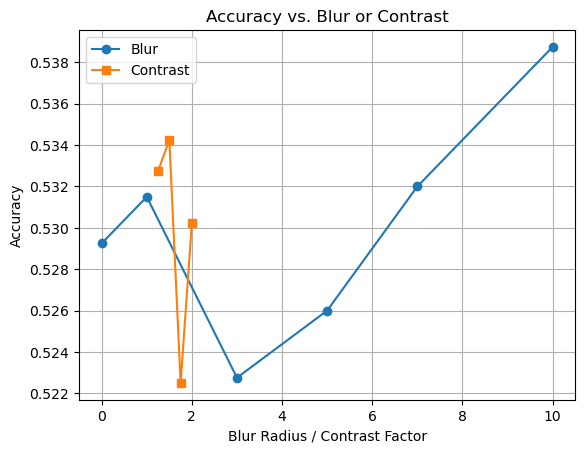

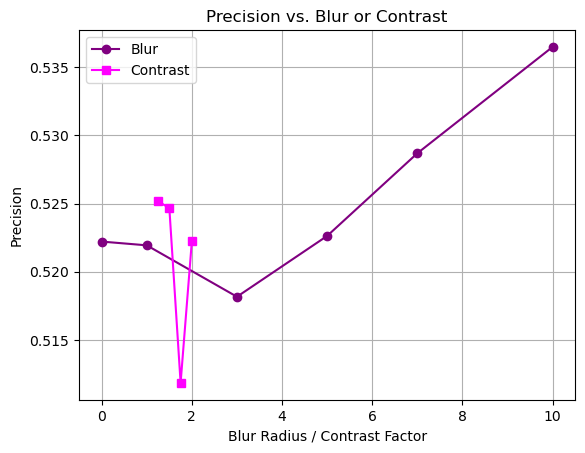

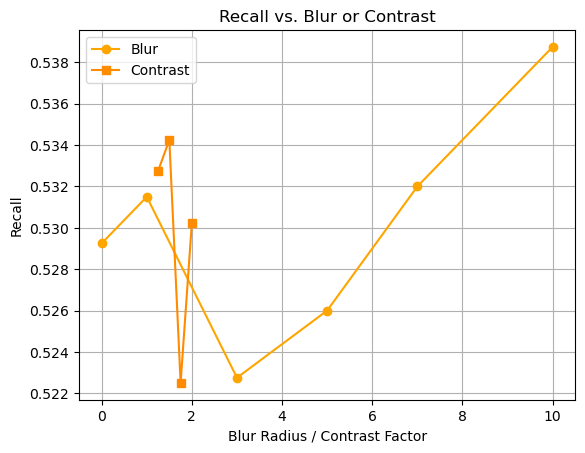

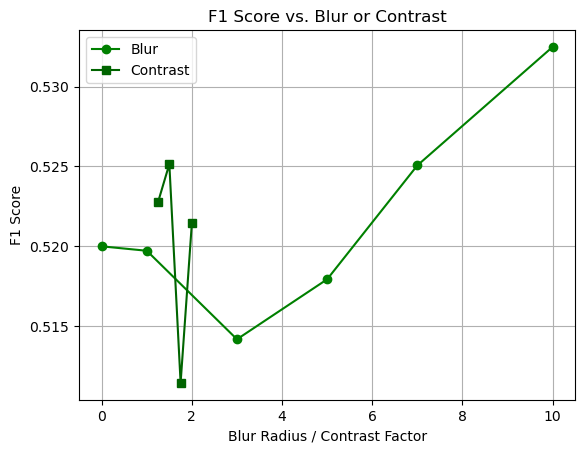

In [14]:
# Separate blur and contrast from combined 'results' list
blur_results = [r for r in results if "blur_radius" in r]
contrast_results = [r for r in results if "contrast_factor" in r]

# Extract metrics for blur
blur_radii = [r["blur_radius"] for r in blur_results]
blur_accuracies = [r["accuracy"] for r in blur_results]
blur_precisions = [r["precision"] for r in blur_results]
blur_recalls = [r["recall"] for r in blur_results]
blur_f1_scores = [r["f1"] for r in blur_results]

# Extract metrics for contrast
contrast_factors = [r["contrast_factor"] for r in contrast_results]
contrast_accuracies = [r["accuracy"] for r in contrast_results]
contrast_precisions = [r["precision"] for r in contrast_results]
contrast_recalls = [r["recall"] for r in contrast_results]
contrast_f1_scores = [r["f1"] for r in contrast_results]

# Accuracy
plt.figure()
plt.plot(blur_radii, blur_accuracies, marker='o', label='Blur')
plt.plot(contrast_factors, contrast_accuracies, marker='s', label='Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Blur or Contrast")
plt.legend()
plt.grid(True)
plt.show()

# Precision
plt.figure()
plt.plot(blur_radii, blur_precisions, marker='o', color='purple', label='Blur')
plt.plot(contrast_factors, contrast_precisions, marker='s', color='magenta', label='Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Precision")
plt.title("Precision vs. Blur or Contrast")
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure()
plt.plot(blur_radii, blur_recalls, marker='o', color='orange', label='Blur')
plt.plot(contrast_factors, contrast_recalls, marker='s', color='darkorange', label='Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Recall")
plt.title("Recall vs. Blur or Contrast")
plt.legend()
plt.grid(True)
plt.show()

# F1 Score
plt.figure()
plt.plot(blur_radii, blur_f1_scores, marker='o', color='green', label='Blur')
plt.plot(contrast_factors, contrast_f1_scores, marker='s', color='darkgreen', label='Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Blur or Contrast")
plt.legend()
plt.grid(True)
plt.show()

### Computing Histogram of Gradient (HOG) Features 

In [14]:
from skimage.feature import hog
from PIL import Image

def extract_hog_features(images):
    hog_features = []
    for img in images:
        # convert to grayscale
        if img.shape[-1] == 3:
            img = Image.fromarray(img.astype(np.uint8)).convert("L")
            img = np.array(img)
        features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

### HOG Baseline Model

In [17]:
hog_results = []

start_idx = len(hog_results)  # Not essential here, but consistent

# Baseline
print("=== Baseline (no blur, HOG) ===")
X_train_hog = extract_hog_features(Xmat_train)
X_test_hog = extract_hog_features(Xmat_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_hog, y_train_enc)
y_pred = model.predict(X_test_hog)

acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average='weighted')
prec = precision_score(y_test_enc, y_pred, average='weighted')
rec = recall_score(y_test_enc, y_pred, average='weighted')
cm = confusion_matrix(y_test_enc, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)
print("Confusion Matrix:\n", cm)
print("\n")

hog_results.append({
    "blur_radius": None,
    "accuracy": acc,
    "f1": f1,
    "precision": prec,
    "recall": rec,
    "confusion_matrix": cm
})

new_entries = hog_results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = True    
    r["pca"] = False  
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

df

=== Baseline (no blur, HOG) ===
Accuracy: 0.38425
F1 Score: 0.37907759092452326
Precision: 0.3761479175230449
Recall: 0.38425
Confusion Matrix:
 [[523 173 179 125]
 [242 239 255 264]
 [217 223 308 252]
 [124 215 194 467]]




/var/folders/hd/b6p137bx33s_ynzy0mhn1_zm0000gn/T/ipykernel_31305/994641366.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_block], ignore_index=True)


,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,NaN,0,False,False,0.52925,0.519992,0.522213,0.52925
1,NaN,1,False,False,0.53150,0.519715,0.521938,0.53150
2,NaN,3,False,False,0.52275,0.514171,0.518166,0.52275
3,NaN,5,False,False,0.52600,0.517929,0.522628,0.52600
4,NaN,7,False,False,0.53200,0.525059,0.528691,0.53200
5,NaN,10,False,False,0.53875,0.532481,0.536493,0.53875
6,1.25,None,False,False,0.53275,0.522767,0.525167,0.53275
7,1.50,None,False,False,0.53425,0.525143,0.524675,0.53425
8,1.75,None,False,False,0.52250,0.511438,0.511844,0.52250
9,2.00,None,False,False,0.53025,0.521455,0.522270,0.53025


### HOG with Blur Model

In [20]:
start_idx = len(hog_results)  # Not essential here, but consistent

for radius in [1, 3, 5, 7, 10]:
    print(f"=== HOG with blur radius {radius} ===")
    
    X_blur_train = shiny_data.apply_blur(Xmat_train, radius)
    X_blur_test = shiny_data.apply_blur(Xmat_test, radius)

    X_train_hog = extract_hog_features(X_blur_train)
    X_test_hog = extract_hog_features(X_blur_test)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_hog, y_train_enc)
    y_pred = model.predict(X_test_hog)

    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    prec = precision_score(y_test_enc, y_pred, average='weighted')
    rec = recall_score(y_test_enc, y_pred, average='weighted')
    cm = confusion_matrix(y_test_enc, y_pred)
    
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Confusion Matrix:\n", cm)
    print("\n")

    hog_results.append({
        "blur_radius": radius,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "confusion_matrix": cm
    })

new_entries = hog_results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = True    
    r["pca"] = False  
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

df

=== HOG with blur radius 1 ===
Accuracy: 0.35
F1 Score: 0.34820674730625706
Precision: 0.3473227574225505
Recall: 0.35
Confusion Matrix:
 [[434 206 179 181]
 [243 247 260 250]
 [218 231 371 180]
 [219 235 198 348]]


=== HOG with blur radius 3 ===
Accuracy: 0.3265
F1 Score: 0.32613397815029255
Precision: 0.32717776652206854
Recall: 0.3265
Confusion Matrix:
 [[364 205 169 262]
 [248 269 269 214]
 [247 227 352 174]
 [306 224 149 321]]


=== HOG with blur radius 5 ===
Accuracy: 0.35675
F1 Score: 0.35470324114874247
Precision: 0.35533900189976847
Recall: 0.35675
Confusion Matrix:
 [[397 172 159 272]
 [247 252 270 231]
 [197 193 428 182]
 [318 189 143 350]]


=== HOG with blur radius 7 ===
Accuracy: 0.34625
F1 Score: 0.3445070093309688
Precision: 0.34585114395887695
Recall: 0.34625
Confusion Matrix:
 [[400 157 143 300]
 [238 244 279 239]
 [193 220 405 182]
 [352 187 125 336]]


=== HOG with blur radius 10 ===
Accuracy: 0.36225
F1 Score: 0.3615415112666485
Precision: 0.3622980904839562
Recal

/var/folders/hd/b6p137bx33s_ynzy0mhn1_zm0000gn/T/ipykernel_31305/2612090516.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_block], ignore_index=True)


,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,NaN,0,False,False,0.52925,0.519992,0.522213,0.52925
1,NaN,1,False,False,0.53150,0.519715,0.521938,0.53150
2,NaN,3,False,False,0.52275,0.514171,0.518166,0.52275
3,NaN,5,False,False,0.52600,0.517929,0.522628,0.52600
4,NaN,7,False,False,0.53200,0.525059,0.528691,0.53200
5,NaN,10,False,False,0.53875,0.532481,0.536493,0.53875
6,1.25,None,False,False,0.53275,0.522767,0.525167,0.53275
7,1.50,None,False,False,0.53425,0.525143,0.524675,0.53425
8,1.75,None,False,False,0.52250,0.511438,0.511844,0.52250
9,2.00,None,False,False,0.53025,0.521455,0.522270,0.53025


### HOG with Contrast Model

In [23]:
start_idx = len(hog_results)  # Not essential here, but consistent

for contrast_factor in [1.25, 1.5, 1.75, 2]:
    print(f"=== HOG with contrast factor {contrast_factor} ===")

    # Apply contrast to training and test sets
    X_contrast_train = apply_contrast(Xmat_train, contrast_factor)
    X_contrast_test = apply_contrast(Xmat_test, contrast_factor)

    # Extract HOG features
    X_train_hog = extract_hog_features(X_contrast_train)
    X_test_hog = extract_hog_features(X_contrast_test)

    # Train and evaluate
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_hog, y_train_enc)
    y_pred = model.predict(X_test_hog)

    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    prec = precision_score(y_test_enc, y_pred, average='weighted')
    rec = recall_score(y_test_enc, y_pred, average='weighted')
    cm = confusion_matrix(y_test_enc, y_pred)

    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Confusion Matrix:\n", cm)
    print("\n")

    hog_results.append({
        "contrast_factor": contrast_factor,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "confusion_matrix": cm
    })

new_entries = hog_results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = True    
    r["pca"] = False  
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

df

=== HOG with contrast factor 1.25 ===
Accuracy: 0.25675
F1 Score: 0.14027326713993063
Precision: 0.2792438814693071
Recall: 0.25675
Confusion Matrix:
 [[ 25  16 930  29]
 [ 24  18 927  31]
 [ 23  11 937  29]
 [ 38  17 898  47]]


=== HOG with contrast factor 1.5 ===
Accuracy: 0.37925
F1 Score: 0.3760989317687675
Precision: 0.37403903721006554
Recall: 0.37925
Confusion Matrix:
 [[626 168 119  87]
 [166 312 245 277]
 [142 301 230 327]
 [117 271 263 349]]


=== HOG with contrast factor 1.75 ===
Accuracy: 0.39825
F1 Score: 0.3771409014887829
Precision: 0.38012174359715883
Recall: 0.39825
Confusion Matrix:
 [[769 112  38  81]
 [242 273 144 341]
 [222 265 206 307]
 [228 265 162 345]]


=== HOG with contrast factor 2 ===
Accuracy: 0.40675
F1 Score: 0.39404412868344285
Precision: 0.39568889203196617
Recall: 0.40675
Confusion Matrix:
 [[712 135  60  93]
 [196 328 160 316]
 [185 280 249 286]
 [235 263 164 338]]




,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,NaN,0,False,False,0.52925,0.519992,0.522213,0.52925
1,NaN,1,False,False,0.53150,0.519715,0.521938,0.53150
2,NaN,3,False,False,0.52275,0.514171,0.518166,0.52275
3,NaN,5,False,False,0.52600,0.517929,0.522628,0.52600
4,NaN,7,False,False,0.53200,0.525059,0.528691,0.53200
5,NaN,10,False,False,0.53875,0.532481,0.536493,0.53875
6,1.25,None,False,False,0.53275,0.522767,0.525167,0.53275
7,1.50,None,False,False,0.53425,0.525143,0.524675,0.53425
8,1.75,None,False,False,0.52250,0.511438,0.511844,0.52250
9,2.00,None,False,False,0.53025,0.521455,0.522270,0.53025


### HOG Baseline, Blur, Contrast - Results

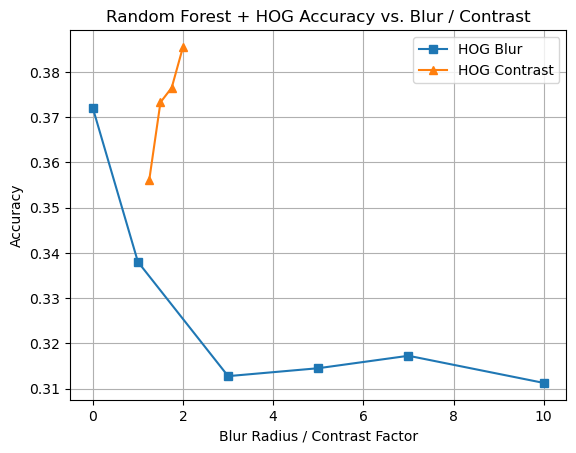

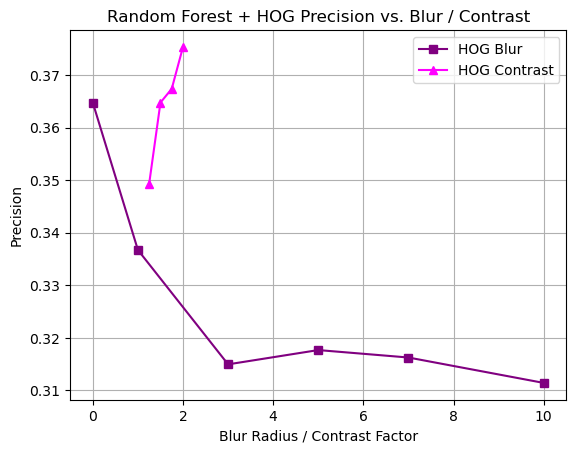

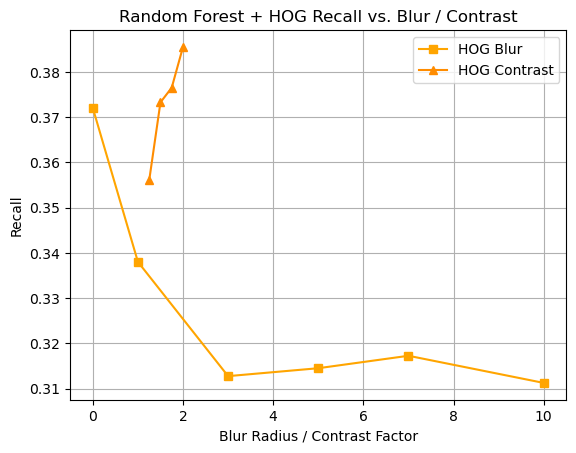

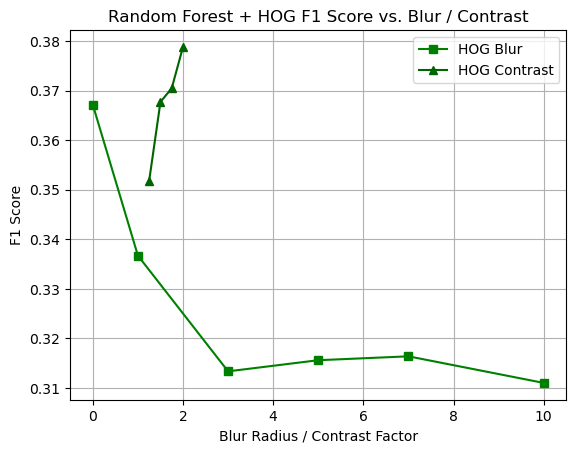

In [24]:
# Split HOG results into blur and contrast
hog_blur_results = [r for r in hog_results if "blur_radius" in r]
hog_contrast_results = [r for r in hog_results if "contrast_factor" in r]

# Extract metrics for HOG + Blur
hog_blur_radii = [r["blur_radius"] for r in hog_blur_results]
hog_blur_accuracies = [r["accuracy"] for r in hog_blur_results]
hog_blur_precisions = [r["precision"] for r in hog_blur_results]
hog_blur_recalls = [r["recall"] for r in hog_blur_results]
hog_blur_f1_scores = [r["f1"] for r in hog_blur_results]

# Extract metrics for HOG + Contrast
hog_contrast_factors = [r["contrast_factor"] for r in hog_contrast_results]
hog_contrast_accuracies = [r["accuracy"] for r in hog_contrast_results]
hog_contrast_precisions = [r["precision"] for r in hog_contrast_results]
hog_contrast_recalls = [r["recall"] for r in hog_contrast_results]
hog_contrast_f1_scores = [r["f1"] for r in hog_contrast_results]

# Accuracy
plt.figure()
plt.plot(hog_blur_radii, hog_blur_accuracies, marker='s', label='HOG Blur')
plt.plot(hog_contrast_factors, hog_contrast_accuracies, marker='^', label='HOG Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Accuracy")
plt.title("Random Forest + HOG Accuracy vs. Blur / Contrast")
plt.legend()
plt.grid(True)
plt.show()

# Precision
plt.figure()
plt.plot(hog_blur_radii, hog_blur_precisions, marker='s', color='purple', label='HOG Blur')
plt.plot(hog_contrast_factors, hog_contrast_precisions, marker='^', color='magenta', label='HOG Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Precision")
plt.title("Random Forest + HOG Precision vs. Blur / Contrast")
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure()
plt.plot(hog_blur_radii, hog_blur_recalls, marker='s', color='orange', label='HOG Blur')
plt.plot(hog_contrast_factors, hog_contrast_recalls, marker='^', color='darkorange', label='HOG Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Recall")
plt.title("Random Forest + HOG Recall vs. Blur / Contrast")
plt.legend()
plt.grid(True)
plt.show()


# F1 Score
plt.figure()
plt.plot(hog_blur_radii, hog_blur_f1_scores, marker='s', color='green', label='HOG Blur')
plt.plot(hog_contrast_factors, hog_contrast_f1_scores, marker='^', color='darkgreen', label='HOG Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("F1 Score")
plt.title("Random Forest + HOG F1 Score vs. Blur / Contrast")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
## PCA

In [26]:
from sklearn.decomposition import PCA

# Flatten raw images
X_train_flat = Xmat_train.reshape(Xmat_train.shape[0], -1)
X_test_flat = Xmat_test.reshape(Xmat_test.shape[0], -1)

# Apply PCA
pca = PCA(n_components=100)  # You can tune this number
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

### PCA Base Model

In [25]:
from sklearn.decomposition import PCA

pca_results = []

start_idx = len(pca_results)

# Baseline
print("=== Baseline (no blur, PCA) ===")
X_train_flat = Xmat_train.reshape(Xmat_train.shape[0], -1)
X_test_flat = Xmat_test.reshape(Xmat_test.shape[0], -1)

pca = PCA(n_components=100)  # You can adjust this
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train_enc)
y_pred = model.predict(X_test_pca)

acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average='weighted')
prec = precision_score(y_test_enc, y_pred, average='weighted')
rec = recall_score(y_test_enc, y_pred, average='weighted')
cm = confusion_matrix(y_test_enc, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)
print("Confusion Matrix:\n", cm)
print("\n")

pca_results.append({
    "blur_radius": 0,
    "accuracy": acc,
    "f1": f1,
    "precision": prec,
    "recall": rec,
    "confusion_matrix": cm
})

new_entries = pca_results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = False    
    r["pca"] = True  
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

df

=== Baseline (no blur, PCA) ===
Accuracy: 0.501
F1 Score: 0.4892858698018895
Precision: 0.5066523679247582
Recall: 0.501
Confusion Matrix:
 [[499 143  98 260]
 [119 282 217 382]
 [ 97 215 449 239]
 [120  87  19 774]]




/var/folders/hd/b6p137bx33s_ynzy0mhn1_zm0000gn/T/ipykernel_31305/1161904204.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_block], ignore_index=True)


,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,NaN,0,False,False,0.52925,0.519992,0.522213,0.52925
1,NaN,1,False,False,0.53150,0.519715,0.521938,0.53150
2,NaN,3,False,False,0.52275,0.514171,0.518166,0.52275
3,NaN,5,False,False,0.52600,0.517929,0.522628,0.52600
4,NaN,7,False,False,0.53200,0.525059,0.528691,0.53200
5,NaN,10,False,False,0.53875,0.532481,0.536493,0.53875
6,1.25,None,False,False,0.53275,0.522767,0.525167,0.53275
7,1.50,None,False,False,0.53425,0.525143,0.524675,0.53425
8,1.75,None,False,False,0.52250,0.511438,0.511844,0.52250
9,2.00,None,False,False,0.53025,0.521455,0.522270,0.53025


### PCA Blur Model

In [27]:
start_idx = len(pca_results)

# Loop over blur
for radius in [1, 3, 5, 7, 10]:
    print(f"=== PCA with blur radius {radius} ===")

    X_blur_train = shiny_data.apply_blur(Xmat_train, radius)
    X_blur_test = shiny_data.apply_blur(Xmat_test, radius)

    X_train_flat = X_blur_train.reshape(X_blur_train.shape[0], -1)
    X_test_flat = X_blur_test.reshape(X_blur_test.shape[0], -1)

    pca = PCA(n_components=100)
    X_train_pca = pca.fit_transform(X_train_flat)
    X_test_pca = pca.transform(X_test_flat)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_pca, y_train_enc)
    y_pred = model.predict(X_test_pca)

    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    prec = precision_score(y_test_enc, y_pred, average='weighted')
    rec = recall_score(y_test_enc, y_pred, average='weighted')
    cm = confusion_matrix(y_test_enc, y_pred)

    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Confusion Matrix:\n", cm)
    print("\n")

    pca_results.append({
        "blur_radius": radius,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "confusion_matrix": cm
    })

new_entries = pca_results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = False    
    r["pca"] = True  
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

df

=== PCA with blur radius 1 ===
Accuracy: 0.50125
F1 Score: 0.4846690816603876
Precision: 0.500640216491027
Recall: 0.50125
Confusion Matrix:
 [[523 119 104 254]
 [128 239 233 400]
 [108 207 448 237]
 [105  65  35 795]]


=== PCA with blur radius 3 ===
Accuracy: 0.49
F1 Score: 0.4755666455212545
Precision: 0.4876990016468251
Recall: 0.49
Confusion Matrix:
 [[508 131 104 257]
 [141 246 245 368]
 [110 212 444 234]
 [132  86  20 762]]


=== PCA with blur radius 5 ===
Accuracy: 0.50575
F1 Score: 0.4915523985171551
Precision: 0.5050945574272293
Recall: 0.50575
Confusion Matrix:
 [[550 116 101 233]
 [135 261 225 379]
 [123 201 442 234]
 [121  86  23 770]]


=== PCA with blur radius 7 ===
Accuracy: 0.50975
F1 Score: 0.49197814818416874
Precision: 0.5037037858129636
Recall: 0.50975
Confusion Matrix:
 [[580 107  97 216]
 [142 229 245 384]
 [122 194 447 237]
 [117  80  20 783]]


=== PCA with blur radius 10 ===
Accuracy: 0.5185
F1 Score: 0.5024157577957854
Precision: 0.5123997501986043
Recall: 0.

/var/folders/hd/b6p137bx33s_ynzy0mhn1_zm0000gn/T/ipykernel_31305/3498797376.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_block], ignore_index=True)


,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,NaN,0,False,False,0.52925,0.519992,0.522213,0.52925
1,NaN,1,False,False,0.53150,0.519715,0.521938,0.53150
2,NaN,3,False,False,0.52275,0.514171,0.518166,0.52275
3,NaN,5,False,False,0.52600,0.517929,0.522628,0.52600
4,NaN,7,False,False,0.53200,0.525059,0.528691,0.53200
5,NaN,10,False,False,0.53875,0.532481,0.536493,0.53875
6,1.25,None,False,False,0.53275,0.522767,0.525167,0.53275
7,1.50,None,False,False,0.53425,0.525143,0.524675,0.53425
8,1.75,None,False,False,0.52250,0.511438,0.511844,0.52250
9,2.00,None,False,False,0.53025,0.521455,0.522270,0.53025


### PCA Contrast Model

In [29]:
start_idx = len(pca_results)

for contrast_factor in [1.25, 1.5, 1.75, 2]:
    print(f"=== PCA with contrast factor {contrast_factor} ===")

    # Apply contrast to train and test images
    X_contrast_train = apply_contrast(Xmat_train, contrast_factor)
    X_contrast_test = apply_contrast(Xmat_test, contrast_factor)

    # Flatten the images
    X_train_flat = X_contrast_train.reshape(X_contrast_train.shape[0], -1)
    X_test_flat = X_contrast_test.reshape(X_contrast_test.shape[0], -1)

    # Apply PCA
    pca = PCA(n_components=100)
    X_train_pca = pca.fit_transform(X_train_flat)
    X_test_pca = pca.transform(X_test_flat)

    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_pca, y_train_enc)
    y_pred = model.predict(X_test_pca)

    # Evaluate
    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    prec = precision_score(y_test_enc, y_pred, average='weighted')
    rec = recall_score(y_test_enc, y_pred, average='weighted')
    cm = confusion_matrix(y_test_enc, y_pred)

    # Output and store
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Confusion Matrix:\n", cm)
    print("\n")

    pca_results.append({
        "contrast_factor": contrast_factor,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "confusion_matrix": cm
    })

new_entries = pca_results[start_idx:]

for r in new_entries:
    r["blur_radius"] = r.get("blur_radius", None)
    r["contrast_factor"] = r.get("contrast_factor", None)
    r["hog"] = False    
    r["pca"] = True  
    r.pop("confusion_matrix", None)

df_block = pd.DataFrame(new_entries).rename(columns={
    "blur_radius": "Blur",
    "contrast_factor": "Contrast"
})[["Contrast", "Blur", "hog", "pca", "accuracy", "f1", "precision", "recall"]]

df = pd.concat([df, df_block], ignore_index=True)

df

=== PCA with contrast factor 1.25 ===
Accuracy: 0.503
F1 Score: 0.48821148145515725
Precision: 0.5036043315294703
Recall: 0.503
Confusion Matrix:
 [[520 132  94 254]
 [134 254 237 375]
 [106 201 449 244]
 [106  85  20 789]]


=== PCA with contrast factor 1.5 ===
Accuracy: 0.51175
F1 Score: 0.4960312919140233
Precision: 0.5122487034933388
Recall: 0.51175
Confusion Matrix:
 [[522 122 107 249]
 [121 252 245 382]
 [111 177 475 237]
 [100  75  27 798]]


=== PCA with contrast factor 1.75 ===
Accuracy: 0.51775
F1 Score: 0.5011910210079638
Precision: 0.5195907218113001
Recall: 0.51775
Confusion Matrix:
 [[533 118 108 241]
 [111 256 228 405]
 [121 200 449 230]
 [ 62  87  18 833]]


=== PCA with contrast factor 2 ===
Accuracy: 0.521
F1 Score: 0.5051455871152949
Precision: 0.5189403446386727
Recall: 0.521
Confusion Matrix:
 [[560 112 114 214]
 [133 253 222 392]
 [122 184 469 225]
 [ 86  91  21 802]]




,Contrast,Blur,hog,pca,accuracy,f1,precision,recall
0,NaN,0,False,False,0.52925,0.519992,0.522213,0.52925
1,NaN,1,False,False,0.53150,0.519715,0.521938,0.53150
2,NaN,3,False,False,0.52275,0.514171,0.518166,0.52275
3,NaN,5,False,False,0.52600,0.517929,0.522628,0.52600
4,NaN,7,False,False,0.53200,0.525059,0.528691,0.53200
5,NaN,10,False,False,0.53875,0.532481,0.536493,0.53875
6,1.25,None,False,False,0.53275,0.522767,0.525167,0.53275
7,1.50,None,False,False,0.53425,0.525143,0.524675,0.53425
8,1.75,None,False,False,0.52250,0.511438,0.511844,0.52250
9,2.00,None,False,False,0.53025,0.521455,0.522270,0.53025


### PCA Baseline, Blur, and Contrast - Results

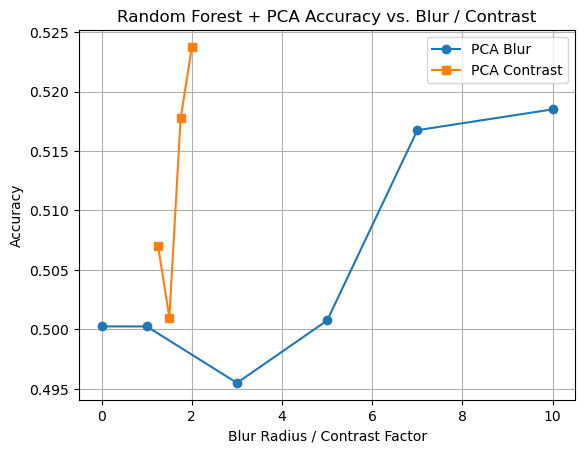

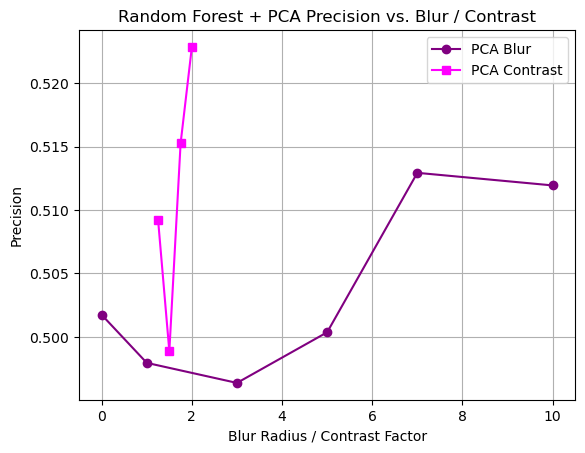

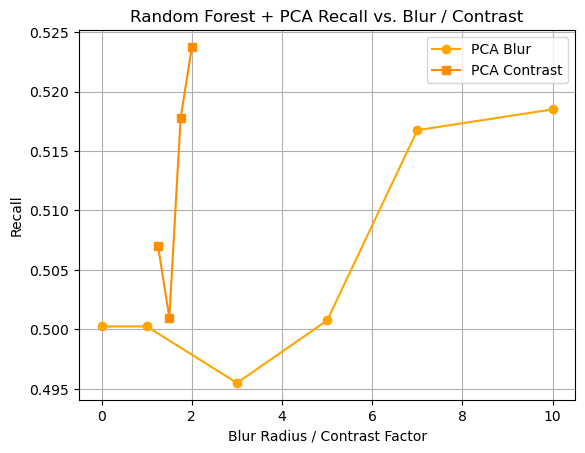

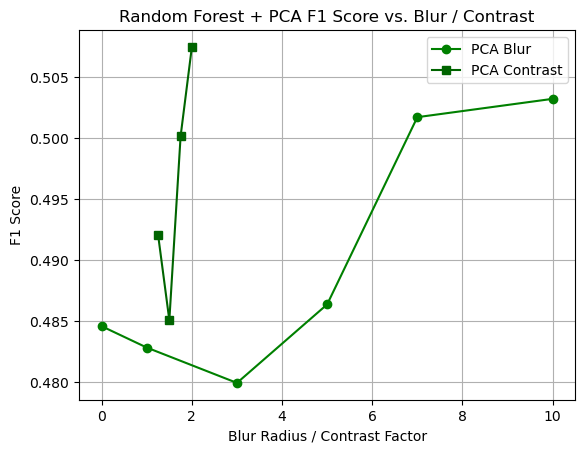

In [34]:
# Split PCA results into blur and contrast
pca_blur_results = [r for r in pca_results if "blur_radius" in r]
pca_contrast_results = [r for r in pca_results if "contrast_factor" in r]

# Extract blur metrics
pca_blur_radii = [r["blur_radius"] for r in pca_blur_results]
pca_blur_accuracies = [r["accuracy"] for r in pca_blur_results]
pca_blur_precisions = [r["precision"] for r in pca_blur_results]
pca_blur_recalls = [r["recall"] for r in pca_blur_results]
pca_blur_f1_scores = [r["f1"] for r in pca_blur_results]

# Extract contrast metrics
pca_contrast_factors = [r["contrast_factor"] for r in pca_contrast_results]
pca_contrast_accuracies = [r["accuracy"] for r in pca_contrast_results]
pca_contrast_precisions = [r["precision"] for r in pca_contrast_results]
pca_contrast_recalls = [r["recall"] for r in pca_contrast_results]
pca_contrast_f1_scores = [r["f1"] for r in pca_contrast_results]

# Accuracy
plt.figure()
plt.plot(pca_blur_radii, pca_blur_accuracies, marker='o', label='PCA Blur')
plt.plot(pca_contrast_factors, pca_contrast_accuracies, marker='s', label='PCA Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Accuracy")
plt.title("Random Forest + PCA Accuracy vs. Blur / Contrast")
plt.legend()
plt.grid(True)
plt.show()

# Precision
plt.figure()
plt.plot(pca_blur_radii, pca_blur_precisions, marker='o', color='purple', label='PCA Blur')
plt.plot(pca_contrast_factors, pca_contrast_precisions, marker='s', color='magenta', label='PCA Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Precision")
plt.title("Random Forest + PCA Precision vs. Blur / Contrast")
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure()
plt.plot(pca_blur_radii, pca_blur_recalls, marker='o', color='orange', label='PCA Blur')
plt.plot(pca_contrast_factors, pca_contrast_recalls, marker='s', color='darkorange', label='PCA Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("Recall")
plt.title("Random Forest + PCA Recall vs. Blur / Contrast")
plt.legend()
plt.grid(True)
plt.show()

# F1 Score
plt.figure()
plt.plot(pca_blur_radii, pca_blur_f1_scores, marker='o', color='green', label='PCA Blur')
plt.plot(pca_contrast_factors, pca_contrast_f1_scores, marker='s', color='darkgreen', label='PCA Contrast')
plt.xlabel("Blur Radius / Contrast Factor")
plt.ylabel("F1 Score")
plt.title("Random Forest + PCA F1 Score vs. Blur / Contrast")
plt.legend()
plt.grid(True)
plt.show()

# Pairwise combos - With and Without HOG & PCA

In [36]:
combined_results = []

for feature_type in ["pixel", "hog", "pca"]:
    for blur_radius in [1, 3, 5, 7, 10]:
        for contrast_factor in [1.25, 1.5, 1.75, 2]:
            # Step 1: Apply blur
            X_blur_train = shiny_data.apply_blur(Xmat_train, blur_radius)
            X_blur_test = shiny_data.apply_blur(Xmat_test, blur_radius)

            # Step 2: Apply contrast to the blurred images
            X_bc_train = apply_contrast(X_blur_train, contrast_factor)
            X_bc_test = apply_contrast(X_blur_test, contrast_factor)

            # Step 3: Feature extraction based on type
            if feature_type == "pixel":
                X_train = X_bc_train.reshape(X_bc_train.shape[0], -1)
                X_test = X_bc_test.reshape(X_bc_test.shape[0], -1)

            elif feature_type == "hog":
                X_train = extract_hog_features(X_bc_train)
                X_test = extract_hog_features(X_bc_test)

            elif feature_type == "pca":
                X_flat_train = X_bc_train.reshape(X_bc_train.shape[0], -1)
                X_flat_test = X_bc_test.reshape(X_bc_test.shape[0], -1)
                pca = PCA(n_components=100)
                X_train = pca.fit_transform(X_flat_train)
                X_test = pca.transform(X_flat_test)

            # Step 4: Train and evaluate
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train_enc)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test_enc, y_pred)
            f1 = f1_score(y_test_enc, y_pred, average='weighted')
            prec = precision_score(y_test_enc, y_pred, average='weighted')
            rec = recall_score(y_test_enc, y_pred, average='weighted')
            cm = confusion_matrix(y_test_enc, y_pred)

            # Step 5: Store results
            combined_results.append({
                "feature_type": feature_type,
                "blur_radius": blur_radius,
                "contrast_factor": contrast_factor,
                "accuracy": acc,
                "f1": f1,
                "precision": prec,
                "recall": rec,
                "confusion_matrix": cm
            })

for r in combined_results:
    print(f"=== Feature: {r['feature_type']} | Blur: {r['blur_radius']} | Contrast: {r['contrast_factor']} ===")
    print(f"Accuracy:  {r['accuracy']:.4f}")
    print(f"F1 Score:  {r['f1']:.4f}")
    print(f"Precision: {r['precision']:.4f}")
    print(f"Recall:    {r['recall']:.4f}")
    print("Confusion Matrix:\n", r["confusion_matrix"])
    print("\n")

=== Feature: pixel | Blur: 1 | Contrast: 1.25 ===
Accuracy:  0.5262
F1 Score:  0.5170
Precision: 0.5189
Recall:    0.5262
Confusion Matrix:
 [[576 146 118 160]
 [152 296 255 297]
 [131 252 467 150]
 [ 55 147  32 766]]


=== Feature: pixel | Blur: 1 | Contrast: 1.5 ===
Accuracy:  0.5262
F1 Score:  0.5168
Precision: 0.5168
Recall:    0.5262
Confusion Matrix:
 [[580 139 123 158]
 [160 293 258 289]
 [139 230 488 143]
 [ 78 141  37 744]]


=== Feature: pixel | Blur: 1 | Contrast: 1.75 ===
Accuracy:  0.5238
F1 Score:  0.5137
Precision: 0.5156
Recall:    0.5238
Confusion Matrix:
 [[585 160 101 154]
 [153 285 248 314]
 [145 227 469 159]
 [ 69 142  33 756]]


=== Feature: pixel | Blur: 1 | Contrast: 2 ===
Accuracy:  0.5375
F1 Score:  0.5275
Precision: 0.5284
Recall:    0.5375
Confusion Matrix:
 [[602 142 105 151]
 [166 302 238 294]
 [145 228 482 145]
 [ 61 135  40 764]]


=== Feature: pixel | Blur: 3 | Contrast: 1.25 ===
Accuracy:  0.5218
F1 Score:  0.5140
Precision: 0.5170
Recall:    0.5218
Co

## All pairwise results

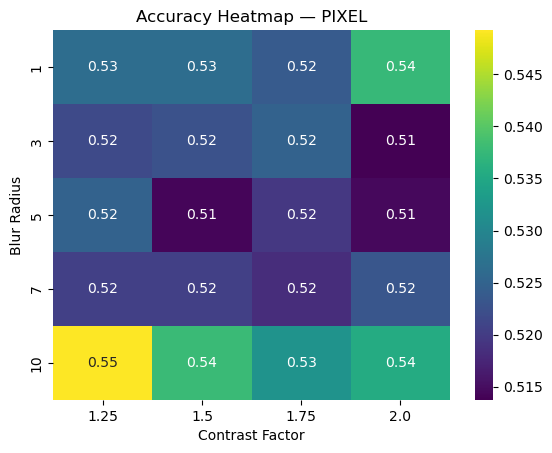

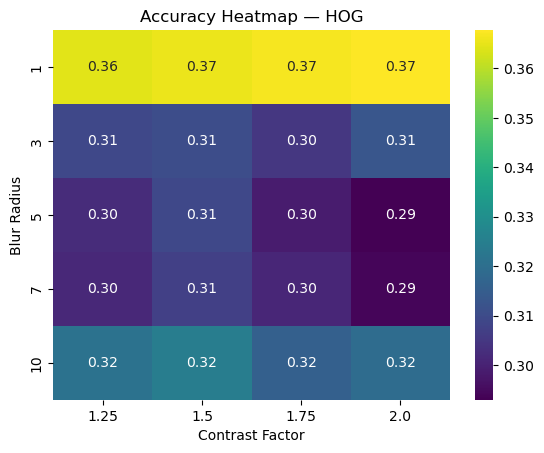

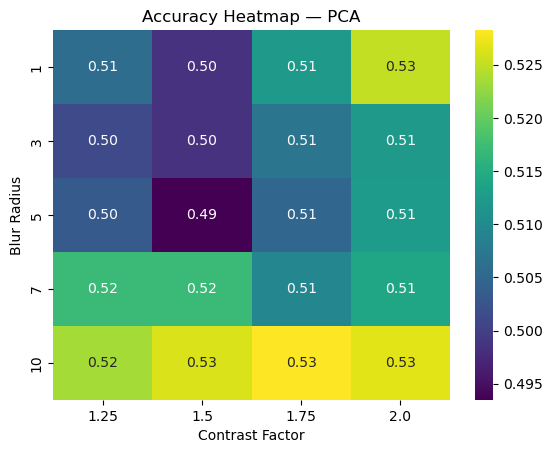

In [38]:
import seaborn as sns
import pandas as pd

# Turn results into a DataFrame
df = pd.DataFrame(combined_results)

# Filter by feature type
for ft in df["feature_type"].unique():
    df_ft = df[df["feature_type"] == ft]

    plt.figure()
    sns.heatmap(
        df_ft.pivot(index="blur_radius", columns="contrast_factor", values="accuracy"),
        annot=True, fmt=".2f", cmap="viridis"
    )
    plt.title(f"Accuracy Heatmap — {ft.upper()}")
    plt.xlabel("Contrast Factor")
    plt.ylabel("Blur Radius")
    plt.show()